In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, RepeatVector, Embedding, LSTM, TimeDistributed, Concatenate, Activation, Input, Dropout, BatchNormalization
from datasets import load_dataset
from io import BytesIO
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction, sentence_bleu
from keras import regularizers

2024-04-15 17:27:13.312039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 17:27:13.312133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 17:27:13.440477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## CNN Model

In [2]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Excluding the top fully connected layer, using pre-trained weights on imagenet, height width color layers
# Average pooling reduces the dimensionality and helps to prevent overfitting by providing an abstracted form of the features
cnn_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')

# Add a fully connected layer on top of the ResNet50 model
x = Dense(256, activation='relu')(cnn_model.output) # A fully connected layer with 256 units and ReLU activation
# Create the new model
cnn_model = Model(inputs=cnn_model.input, outputs=x)
del x

# new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# cnn_model.summary() # show layer types, output shapes, and the number of parameters

Num GPUs Available:  2
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Load Dataset

In [3]:
train_dataset = load_dataset("jxie/flickr8k", split='train')
test_dataset = load_dataset("jxie/flickr8k", split='test')
valid_dataset = load_dataset("jxie/flickr8k", split='validation')

Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
# A sample of the dataset contents
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x399>,
 'caption_0': 'A black dog is running after a white dog in the snow .',
 'caption_1': 'Black dog chasing brown dog through snow',
 'caption_2': 'Two dogs chase each other across the snowy ground .',
 'caption_3': 'Two dogs play together in the snow .',
 'caption_4': 'Two dogs running through a low lying body of water .'}

In [5]:
train_df = train_dataset.to_pandas()
train_df = train_df.drop(train_df.columns[2:6], axis=1)

test_df = test_dataset.to_pandas()
test_df = test_df.drop(test_df.columns[2:6], axis=1)

valid_df = valid_dataset.to_pandas()
valid_df = valid_df.drop(valid_df.columns[2:6], axis=1)

In [9]:
train_path = train_df["image"].apply(lambda x: x['path'])
test_path = test_df["image"].apply(lambda x: x['path'])
valid_path = valid_df["image"].apply(lambda x: x['path'])
# del train_df, test_df, valid_df

## Dataset Preprocessing
1. Preprocessing Images

In [7]:
def preprocess(img):
  # Resize the image if it's a PIL Image object and directly convert it to a numpy array
  img_resized = img.resize((224, 224), Image.LANCZOS)
  # Convert the resized image to a numpy array
  img_array = np.array(img_resized)
  # Expand dimensions to fit model expected input
  img_array = np.expand_dims(img_array, axis=0)
  # Preprocess the image data to be model compatible
  img_array = preprocess_input(img_array)
  return img_array

In [10]:
train_features = {}
train_images_dir = train_dataset['image']

for img, path in zip(tqdm(train_images_dir), train_path):
  # Change dim for usig ResNet model
  image = preprocess(img)
  # Extract feature
  feature = cnn_model.predict(image, verbose=0).reshape(256)
  # Get image ID
  image_id = path.split('.')[0]
  # print(image_id) # Debugging Statement
  # Store feature
  train_features[image_id] = feature
  # print(train_features) # Debugging Statement
  del img, image

del train_images_dir

  0%|          | 0/6000 [00:00<?, ?it/s]

I0000 00:00:1713202237.396210      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
len(train_features)

6000

In [13]:
test_features = {}
test_images_dir = test_dataset['image']

for i, img in enumerate(tqdm(test_images_dir)):
  # Change dim for using ResNet model
  image = preprocess(img)
  # Extract feature
  feature = cnn_model.predict(image, verbose=0).reshape(256)
  # Get image ID
#   image_id = path.split('.')[0]
  # print(image_id)
  # Store feature
  test_features[i] = feature
  # print(train_features)
  del img, image

del test_images_dir

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
len(test_features)

1000

In [19]:
valid_features = {}
valid_images_dir = valid_dataset['image']

for img, path in zip(tqdm(valid_images_dir), valid_path):
    # Change dim for using ResNet model
    image = preprocess(img)
    # Extract feature
    feature = cnn_model.predict(image, verbose=0).reshape(256)
    # Get image ID
    image_id = path.split('.')[0]
    # Store feature
    valid_features[image_id] = feature
    del img, image

del valid_images_dir

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
len(valid_features)

1000

2. Preprocessing Captions

In [22]:
caption_0 = train_dataset['caption_0']
caption_1 = train_dataset['caption_1']
caption_2 = train_dataset['caption_2']
caption_3 = train_dataset['caption_3']
caption_4 = train_dataset['caption_4']

# Concatenate all captions into a single 1-dimensional array
train_captions = np.concatenate([caption_0, caption_1, caption_2, caption_3, caption_4])

del caption_1, caption_2, caption_3, caption_4

longest_caption = max(train_captions, key=len)

max_caption_len = len(longest_caption.split())


In [24]:
# Combine all text data into a single string
all_text = ' '.join(train_captions)

# Delete digits, special characters, etc...
all_text = all_text.replace('[^A-Za-z]', '')

# Split the text into lowercase words and add start and end tags
words = ['<S>'] + all_text.split() + ['<E>']

# Create a set to store unique words (vocab)
vocab = set(words)

vocab.add("<UNK>")

del all_text

# vocab = vocab - {""}
vocab_size = len(vocab)

In [26]:
max_caption_len

38

In [27]:
train_captions

array(['A black dog is running after a white dog in the snow .',
       'A little baby plays croquet .',
       'A brown dog in the snow has something hot pink in its mouth .',
       ...,
       'A person in a blue hat climbing up a snow covered mountain .',
       'Various members of a family are gathering around a decorated dining table .',
       'The girl in the bathing suit is poised in midair next to the blue water .'],
      dtype='<U199')

In [28]:
# Create a dictionary to map each word to its index in the feature vector
w_to_i = {word: index for index, word in enumerate(vocab)}
i_to_w = {index: word for word, index in w_to_i.items()}

In [29]:
vocab_size

8257

In [31]:
def word_to_index(word, w_to_i):
    return w_to_i.get(word, w_to_i["<UNK>"])  # Return <UNK> index if word is not found

In [32]:
pad_seq = []
subsequent_word = []

# Iterate over each caption in train_captions
for item in range(len(caption_0)):
    part_seq = []
    next_word = []
    # Dividing caption of each image into words
    text = ['<S>'] + caption_0[item].split() + ['<E>']
    text = [word_to_index(word, w_to_i) for word in text]   # Get index for each word

    for i in range(1, len(text)):
        # input sequence
        part_seq.append(text[i-1])  # Start, 1st word, ..., last word
        # output sequence
        next_word.append(text[i])  # 1st word, ..., last word, End

    pad_seq.append(part_seq)
    subsequent_word.append(next_word)

del part_seq, next_word

# Pad the sequences to a fixed length
pad_seq = sequence.pad_sequences(pad_seq, maxlen=max_caption_len, padding='post')
# Pad the subsequent words
subsequent_word = sequence.pad_sequences(subsequent_word, maxlen=max_caption_len, padding='post')

# One-hot encode the subsequent words
subsequent_word_1hot = np.zeros((len(subsequent_word), max_caption_len, vocab_size), dtype=bool)
for i, sentence in enumerate(subsequent_word):
    for j, word_index in enumerate(sentence):
        subsequent_word_1hot[i, j, word_index] = 1

print("Shape of pad_seq:", pad_seq.shape)
print("Shape of subsequent_word_1hot:", subsequent_word_1hot.shape)

del caption_0

Shape of pad_seq: (6000, 38)
Shape of subsequent_word_1hot: (6000, 38, 8257)


In [34]:
val_pad_seq = []
val_subsequent_word = []
valid_captions = valid_dataset['caption_0']

# Iterate over each caption in train_captions
for item in range(len(valid_captions)):
    val_part_seq = []
    val_next_word = []
    # Dividing caption of each image into words
    text = ['<S>'] + valid_captions[item].split() + ['<E>']
    text = [word_to_index(word, w_to_i) for word in text]   # Get index for each word

    for i in range(1, len(text)):
        # input sequence
        val_part_seq.append(text[i-1])  # Start, 1st word, ..., last word
        # output sequence
        val_next_word.append(text[i])  # 1st word, ..., last word, End

    val_pad_seq.append(val_part_seq)
    val_subsequent_word.append(val_next_word)

del val_part_seq, val_next_word

# Pad the sequences to a fixed length
val_pad_seq = sequence.pad_sequences(val_pad_seq, maxlen=max_caption_len, padding='post')
# Pad the subsequent words
val_subsequent_word = sequence.pad_sequences(val_subsequent_word, maxlen=max_caption_len, padding='post')

# One-hot encode the subsequent words
val_subsequent_word_1hot = np.zeros((len(val_subsequent_word), max_caption_len, vocab_size), dtype=bool)
for i, sentence in enumerate(val_subsequent_word):
    for j, word_index in enumerate(sentence):
        val_subsequent_word_1hot[i, j, word_index] = 1

print("Shape of val_pad_seq:", val_pad_seq.shape)
print("Shape of val_subsequent_word_1hot:", val_subsequent_word_1hot.shape)

# del valid_captions

Shape of val_pad_seq: (1000, 38)
Shape of val_subsequent_word_1hot: (1000, 38, 8257)


## RNN Model (LSTM)
1. Define the model

In [35]:
embed_size = 128

# Add an Input layer with the desired shape
img_input = Input(shape=(256,))

# Add a Dense layer
img_output = Dense(embed_size, activation='relu')(img_input)

# Add a RepeatVector layer
img_output = RepeatVector(max_caption_len)(img_output)

img_model = Model(inputs=img_input, outputs=img_output)


In [37]:
# Build the model
img_model.build(input_shape=(None, 256))

# Print the model summary
print(img_model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 38, 128)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,896 (128.50 KB)

 Trainable params: 32,896 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
# Sequence feature model
lang_input = Input(shape=(max_caption_len,))
lang_output = Embedding(input_dim=vocab_size, output_dim=embed_size)(lang_input)
lang_output = LSTM(256, return_sequences=True)(lang_output)
lang_output = TimeDistributed(Dense(embed_size))(lang_output)
lang_model = Model(inputs=lang_input, outputs=lang_output)

In [40]:
# Build the model
lang_model.build(input_shape=(None, max_caption_len))

# Print the model summary
print(lang_model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 38, 128)        │     1,056,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 38, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 38, 128)        │        32,896 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,484,032 (5.66 MB)

 Trainable params: 1,484,032 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

None


In [41]:
# Concatenate the outputs of the two models
concat_output = Concatenate()([img_model.output, lang_model.output])

# Apply LSTM layers with dropout
x = LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(
    concat_output)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout after LSTM layer
x = LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))(
    x)
x = BatchNormalization()(x)  # Add batch normalization 
x = Dropout(0.5)(x)  # Add dropout after LSTM layer

# Output layer
out = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)

# Define the final model
RNN_model = Model(inputs=[img_model.input, lang_model.input], outputs=out)

RNN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Print model summary
RNN_model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 38, 128)   │  1,056,896 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 38, 256)   │    394,240 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 38, 128)   │          0 │ dense_1[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 38, 128)   │     32,896 │ lstm[0][0]        │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38, 256)   │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 38, 128)   │    197,120 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 38, 128)   │        512 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 38, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 38, 128)   │    131,584 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 128)   │        512 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 38, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 38, 8257)  │  1,065,153 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,911,809 (11.11 MB)

 Trainable params: 2,911,297 (11.11 MB)

 Non-trainable params: 512 (2.00 KB)

## Train the model

In [42]:
class BLEUScoreCallback(Callback):
    def __init__(self, val_data, val_texts):
      super(BLEUScoreCallback, self).__init__()
      self.val_data = val_data
      self.val_texts = val_texts

    def on_epoch_end(self, epoch, logs=None):
      pred_probs = self.model.predict(self.val_data)
      pred_texts = np.argmax(pred_probs, axis=-1)  # Convert probabilities to index of max prob.
      
      # Convert indices to strings
      pred_texts = [' '.join(i_to_w[index] for index in pred) for pred in pred_texts]

      # Define a SmoothingFunction object
      smoothing_function = SmoothingFunction()

      # Calculate BLEU score
      bleu_score = corpus_bleu([[text.split()] for text in self.val_texts], [pred.split() for pred in pred_texts], smoothing_function=smoothing_function.method1)
      print(f'BLEU score on validation after epoch {epoch+1}: {bleu_score}')



In [46]:
# Define the path to save the best model
checkpoint_path = 'model_best.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)


In [44]:
train_feature_list = list(train_features.values())
train_feature_list = np.array(train_feature_list).reshape((6000, 256, 1))

val_feature_list = list(valid_features.values())
val_feature_list = np.array(val_feature_list).reshape((1000, 256, 1))

val_data = [val_feature_list, val_pad_seq]  

bleu_callback = BLEUScoreCallback(val_data=val_data, val_texts=valid_captions)

history = RNN_model.fit(
    [train_feature_list, pad_seq],
    subsequent_word_1hot,
    validation_data=(val_data, val_subsequent_word_1hot),  
    epochs=210,
    batch_size=512,
    callbacks=[checkpoint, early_stopping, bleu_callback]
)
RNN_model.save_weights("model.weights.h5")

Epoch 1/210
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.1395 - loss: 16.1531
Epoch 1: val_loss improved from inf to 13.79502, saving model to model_best.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
BLEU score on validation after epoch 1: 0
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 931ms/step - accuracy: 0.1528 - loss: 16.0803 - val_accuracy: 0.6483 - val_loss: 13.7950
Epoch 2/210
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6159 - loss: 12.1999
Epoch 2: val_loss improved from 13.79502 to 11.35130, saving model to model_best.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
BLEU score on validation after epoch 2: 0
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.6170 - loss: 12.1378 - val_accuracy: 0.6483 - val_loss: 11.3513
Epoch 3/210
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6687 - loss: 8.8348
Epoch 3: val_loss improved from 11.35130 to 9.33417, saving model to model_best.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
BLEU score on validation after epoch 3: 0

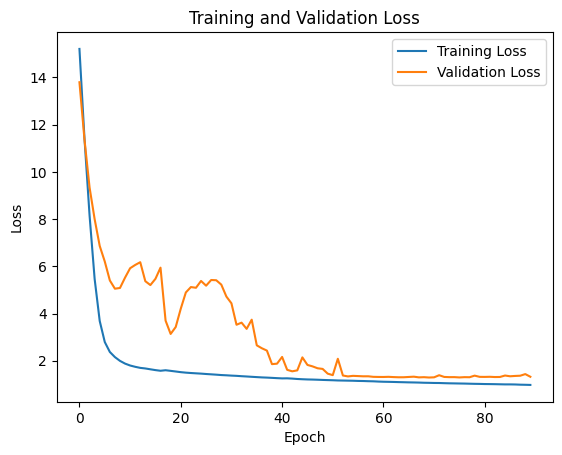

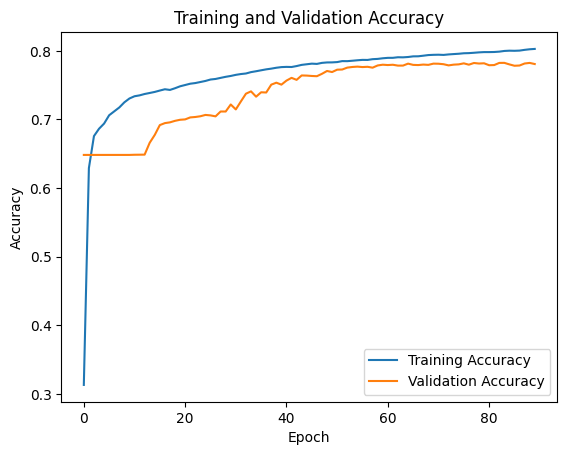

In [47]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Test The Model

In [72]:
def predict_cap(image):
    start_word = ["<S>"]
    counter=0
    while True:
        par_cap = [w_to_i[i] for i in start_word]
        par_cap = sequence.pad_sequences([par_cap], maxlen=max_caption_len, padding='post')
        preds = RNN_model.predict([np.array([image]), np.array(par_cap)], verbose=0)
        xx = np.argmax(preds[0][counter])
        word_pred = i_to_w[xx]
        start_word.append(word_pred)

        if word_pred == "<E>" or len(start_word) > max_caption_len:
            break
        counter+=1

    # Remove <S> and <E> tokens
    predicted_caption = start_word[1:-1]
    # Calculate BLEU score
    smoothing_function = SmoothingFunction()
    bleu_score = sentence_bleu([true_caption], predicted_caption, smoothing_function=smoothing_function.method1)

    return ' '.join(predicted_caption), bleu_score


1. On the Test Dataset:

  0%|          | 0/1000 [00:00<?, ?it/s]

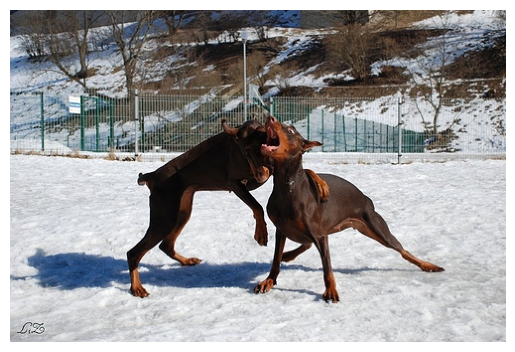

Caption: A brown dog is running on a field .


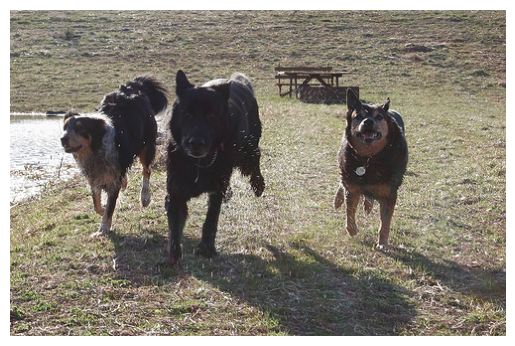

Caption: A brown dog is running through the snow .


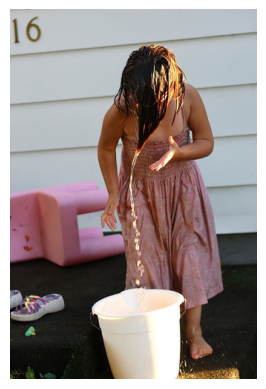

Caption: A man in a black and white dog is standing on a grassy field .


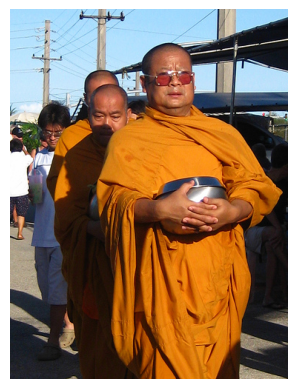

Caption: A man in a red shirt is sitting on a bench .


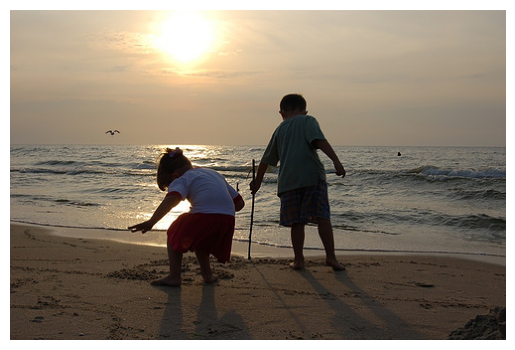

Caption: A man in a red shirt is jumping a surfboard in the water .


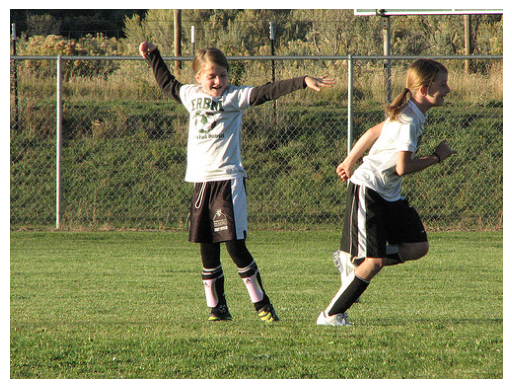

Caption: A boy in a white dog is running on a field of a soccer ball .


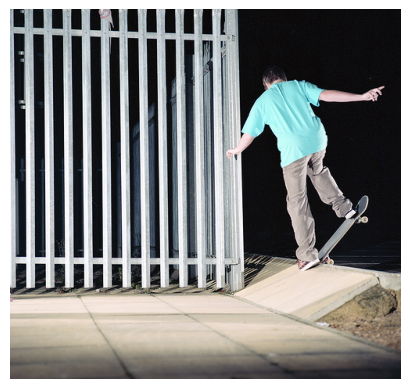

Caption: A man in a red shirt is jumping on a skateboard .


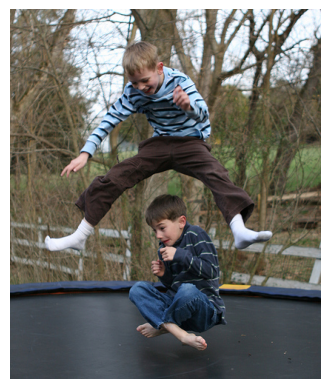

Caption: A man in a red shirt is jumping on a dirt hill .


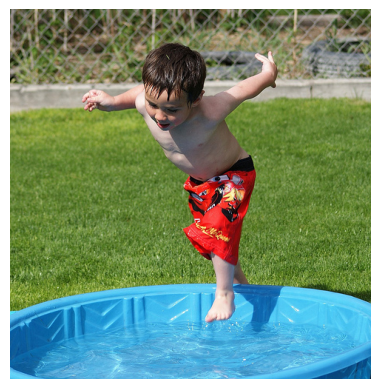

Caption: A boy in a blue shirt is jumping a slide .


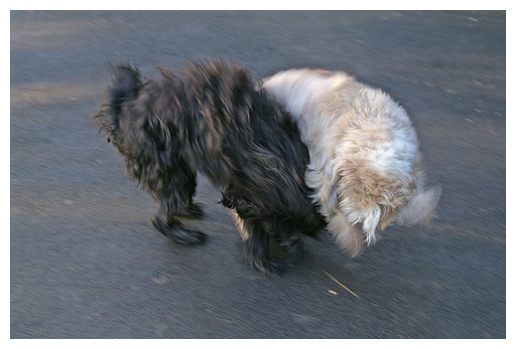

Caption: A dog in a field .


In [55]:
test_feature_list = list(test_features.values())
test_index_list = list(test_features.keys())
test_feature_list = np.array(test_feature_list).reshape((1000, 256, 1))
test_captions = test_dataset['caption_0']

# Calculate accuracy and BLEU score
total_bleu_score = 0
i = 0
for img_feature, index, true_caption in zip(tqdm(test_feature_list), test_index_list, test_captions):
    caption, bleu_score = predict_cap(img_feature, true_caption)
    total_bleu_score += bleu_score
    if i % 100 == 0:
        plt.imshow(test_dataset[index]['image'])
        plt.axis('off')
        plt.show()
        print(f'Caption: {caption}')
    i+=1

## Observations on Captions:
* The model can generate valid English sentences which describe some correct parts of the image.
* The most sensible caption is: "A man in a red shirt is jumping on a skateboard".
* The captions are not perfect because the vocab is not very large and also the corpus of captions is small especially that we trained the model on one caption of the five.

In [57]:
# Calculate average BLEU score
average_bleu_score = total_bleu_score / len(test_features)
print("Average BLEU Score:", average_bleu_score)

Average BLEU Score: 0.0019836361362348086


2. On Images From Internet:

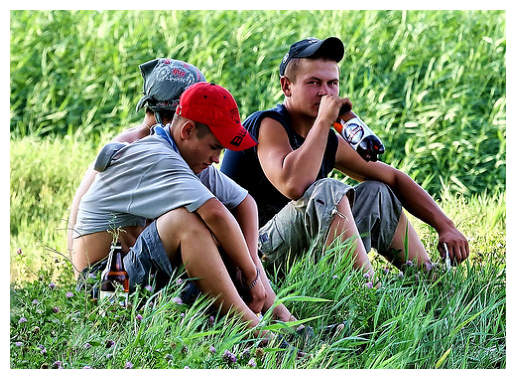

Caption: A man is jumping a ball in a red and white dog .


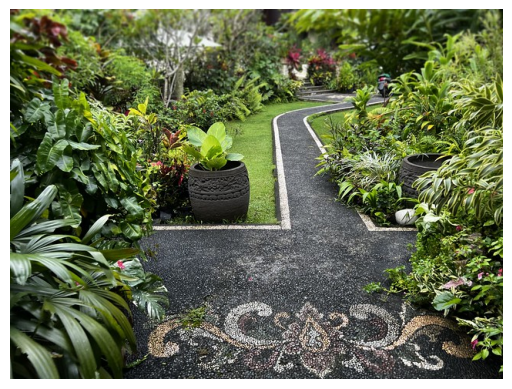

Caption: A brown dog is running on a green ball .


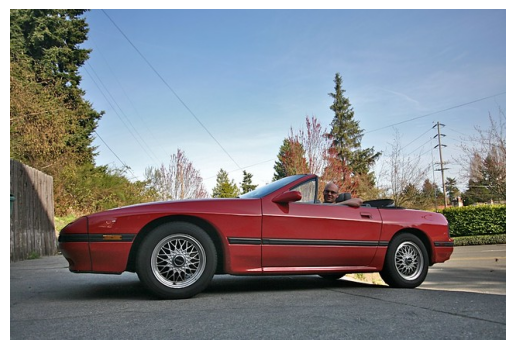

Caption: A brown and white dog is jumping a ball on a large white car .


In [85]:
from pathlib import Path
from PIL import Image
from keras.preprocessing import image

# Define image paths
image_path_1 = Path("../input/images/3080590111_f87f880c8d.jpg")
image_path_2 = Path("../input/images/52736957514_8aa13f3b5f_z.jpg")
image_path_3 = Path("../input/images/7083113519_a7ba3723aa_z.jpg")

# Open images
img1 = Image.open(image_path_1)
img2 = Image.open(image_path_2)
img3 = Image.open(image_path_3)

img1 = image.img_to_array(img1)
img2 = image.img_to_array(img2)
img3 = image.img_to_array(img3)

img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)
img3 = np.expand_dims(img3, axis=0)

img1 = preprocess_input(img1)
img2 = preprocess_input(img2)
img3 = preprocess_input(img3)

feature_1 = cnn_model.predict(img1, verbose=0).reshape(256)
feature_2 = cnn_model.predict(img2, verbose=0).reshape(256)
feature_3 = cnn_model.predict(img3, verbose=0).reshape(256)

feature_1 = np.array(list(feature_1)).reshape(256,1)
feature_2 = np.array(list(feature_2)).reshape(256,1)
feature_3 = np.array(list(feature_3)).reshape(256,1)


image_1 = Image.open(image_path_1)
image_2 = Image.open(image_path_2)
image_3 = Image.open(image_path_3)

caption_1, bleu_score_1 = predict_cap(feature_1)
caption_2, bleu_score_2 = predict_cap(feature_2)
caption_3, bleu_score_3 = predict_cap(feature_3)

# Display the image
plt.imshow(image_1)
plt.axis('off')
plt.show()
print(f'Caption: {caption_1}')

# Display the image
plt.imshow(image_2)
plt.axis('off')
plt.show()
print(f'Caption: {caption_2}')

# Display the image
plt.imshow(image_3)
plt.axis('off')
plt.show()
print(f'Caption: {caption_3}')

## Observations:
* The model detect some related descriptions but it was not very good due to the lack of vocab and small training dataset.